# Carbon Nanotubes: An Application of Machine Learning to Atomic Coordinates

This Jupyter notebook contains a multi-variate feedforward neural network model and a separate gradient-boosted regression tree designed to calculate the coordinates of a given atom $<u', v', w'>$ within a sample of carbon nanotubes given initial coordinates $<u, v, w>$ and chiral indices $n$ and $m$. These results are compared to the atomic coordinates calculated by Density Functional Theory, an extremely popular and accurate quantum mechanical modelling method used in the physical sciences. The neural network utilizes the Adam optimizer, a stochastic gradient-based optimizer. 

To begin, read in the `.csv` file using the `pandas` package and inspect the first few elements.

In [1]:
import pandas as pd

df = pd.read_csv('carbon_nanotubes.csv', sep=';')
df.head()

,Chiral indice n,Chiral indice m,Initial atomic coordinate u,Initial atomic coordinate v,Initial atomic coordinate w,Calculated atomic coordinates u',Calculated atomic coordinates v',Calculated atomic coordinates w'
0,2,1,"0,679005","0,701318","0,017033","0,721039","0,730232","0,017014"
1,2,1,"0,717298","0,642129","0,231319","0,738414","0,65675","0,232369"
2,2,1,"0,489336","0,303751","0,088462","0,477676","0,263221","0,088712"
3,2,1,"0,413957","0,632996","0,040843","0,408823","0,657897","0,039796"
4,2,1,"0,334292","0,543401","0,15989","0,303349","0,558807","0,157373"


Ensure that there is no missing data within the dataset:

In [2]:
df.isna().sum()

Chiral indice n                     0
Chiral indice m                     0
Initial atomic coordinate u         0
Initial atomic coordinate v         0
Initial atomic coordinate w         0
Calculated atomic coordinates u'    0
Calculated atomic coordinates v'    0
Calculated atomic coordinates w'    0
dtype: int64

Notice how all of the atomic coordinates include a comma to represent a decimal value. In order to successfully represent the value as a numeric type in Python, every comma in the dataset will need to be replaced with a period. To achieve this, iterate over the `'object'`-type columns and use a list comprehension to implement the `str.replace()` function. 

In [3]:
for column in df.columns:
    if df[column].dtype=='object':
        df[column] = [float(string.replace(',', '.')) for string in df[column]]
        
df.head()

,Chiral indice n,Chiral indice m,Initial atomic coordinate u,Initial atomic coordinate v,Initial atomic coordinate w,Calculated atomic coordinates u',Calculated atomic coordinates v',Calculated atomic coordinates w'
0,2,1,0.679005,0.701318,0.017033,0.721039,0.730232,0.017014
1,2,1,0.717298,0.642129,0.231319,0.738414,0.656750,0.232369
2,2,1,0.489336,0.303751,0.088462,0.477676,0.263221,0.088712
3,2,1,0.413957,0.632996,0.040843,0.408823,0.657897,0.039796
4,2,1,0.334292,0.543401,0.159890,0.303349,0.558807,0.157373


## Visualizing the Atomic Coordinates

While not exactly necessary for creating the neural network, it may be helpful to visualize the coordinates as points in a three-dimensional space. The plot should reveal a cylindrical tube (hence nanotube) if the data are reasonable. Plotting the initial coordinates:

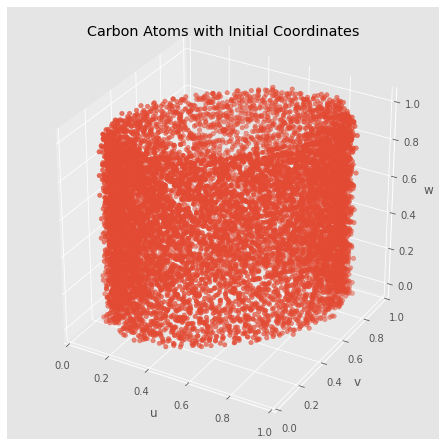

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.style.use('ggplot')

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

u = df['Initial atomic coordinate u'].astype('float')
v = df['Initial atomic coordinate v'].astype('float')
w = df['Initial atomic coordinate w'].astype('float')

plt.title('Carbon Atoms with Initial Coordinates')
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.scatter(u, v, w)
plt.show()

Plotting the atomic coordinates calculated via Density Functional Theory:

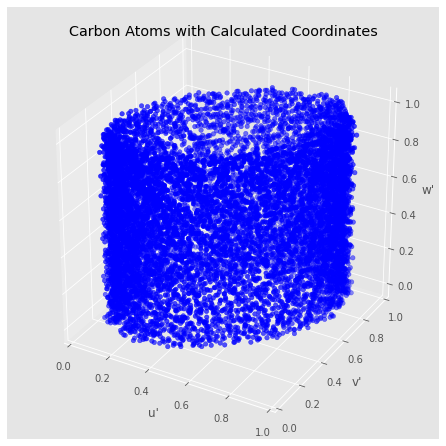

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

up = df['Calculated atomic coordinates u\''].astype('float')
vp = df['Calculated atomic coordinates v\''].astype('float')
wp = df['Calculated atomic coordinates w\''].astype('float')

plt.title('Carbon Atoms with Calculated Coordinates')
ax.set_xlabel('u\'')
ax.set_ylabel('v\'')
ax.set_zlabel('w\'')
ax.scatter(up, vp, wp, c='blue')
plt.show()

## Building a Model with PyTorch

First, instantiate the data matrices $X$ and $y$, then create training and testing sets from either matrices using `train_test_split`. 

Note: A lower-case letter demonstrates a matrix containing dependent variables only for the purpose of this Jupyter notebook -- lower-case lettering typically denotes a *vector* rather than a matrix.

In [6]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-3]
y = df.iloc[:, -3:]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Although a matrix is technically a rank-2 tensor, `torch` still requires an explicit tensor type for its computational graph. Create the data tensors $\mathcal{D}$ and $\mathcal{s}$ using the training sets from $X$ and $y$:

In [7]:
import torch
import torch.nn as nn
import numpy as np

D = torch.Tensor(X_train.values.astype(np.float32))
s = torch.Tensor(y_train.values.astype(np.float32)).view(y_train.shape)

Capture the shapes of $\mathcal{D}$ and $\mathcal{s}$ so that the input size and output size of the neural network are defined correctly. Then, construct a simple feedforward `Sequential` neural network that utilizes the hyperbolic tangent activation function.

$$ tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

In [8]:
D_samples, D_features = D.shape
s_samples, s_features = s.shape

input_size = D_features
output_size = s_features
model = nn.Sequential(nn.Linear(input_size, 15),
                      nn.Tanh(),
                      nn.Linear(15, output_size))

Next, define the learning rate $\eta$, the number of epochs for training the neural network, the loss function $\mathcal{L}$, and the optimizer.

This Jupyter notebook utilizes the mean squared error as its loss function:

$$ \mathcal{L} = \frac{1}{N} \Sigma_{i=1}^{N} (Y_i - \widehat{Y}_i)^2$$

In [9]:
eta = 0.005
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

epochs = 1000

To begin training the neural network, iterate over the entire range of epochs whilst differentiating the computational graph w.r.t. the loss, backpropagating the error, and clearing the accumulated gradients within each epoch. 

In [10]:
from tqdm import tqdm
from sklearn.metrics import r2_score

# Create lists to be able to plot later
epoch_plot = []
loss_plot = []
scores = []

for epoch in tqdm(range(epochs)):
    
    s_predicted = model(D)
    loss = loss_func(s_predicted, s)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_plot.append(epoch + 1)
    loss_plot.append(loss.item())
    
    score = r2_score(s_predicted.detach().numpy(), s)
    scores.append(score)

100%|██████████| 1000/1000 [00:03<00:00, 265.03it/s]


Use `seaborn` to create a lineplot in order to visualize the loss function.

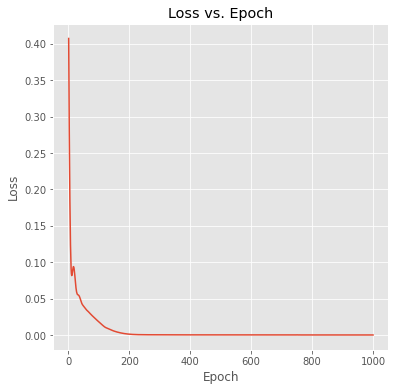

In [117]:
import seaborn as sns

plt.style.use('ggplot')

fig = plt.figure(figsize=(6, 6))
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(epoch_plot, loss_plot);

Obviously $\mathcal{L}$ approaches 0 as the number of epochs tends to infinity, but it is extremely unlikely that the loss has actually reached 0. Give `loss_plot` a quick check to verify this. 

In [12]:
loss_plot[-1]

0.00015020322462078184

Likewise for the `r2_score`, create another lineplot to visualize the evolution of the coefficient of determination. 

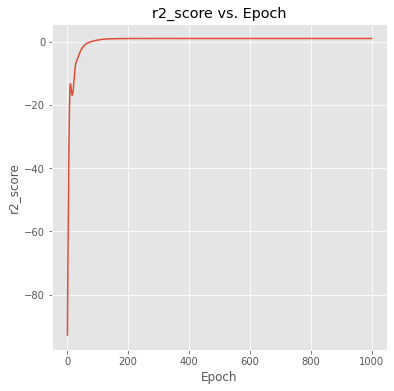

In [118]:
fig = plt.figure(figsize=(6, 6))
plt.title('r2_score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('r2_score')
sns.lineplot(epoch_plot, scores);

Before proceeding any further with visualizations, such as that of the correlation between the predictions made my Density Functional Theory and predictions made by the neural network, define a function which "condenses" a given tensor $\mathcal{T}$ using either the mean $\mu$ or sum $\Sigma$ of each entry in $\mathcal{T}$:

In [14]:
def condense(tensor, method='mean'):
    if method=='sum':
        return [val.detach().numpy().sum() for val in tensor]
    else:
        return [val.detach().numpy().mean() for val in tensor]

With the function having been created, the data tensors can now be condensed and transformed into a form compatible with `seaborn` so that the correlation between the predictions may be visualized.

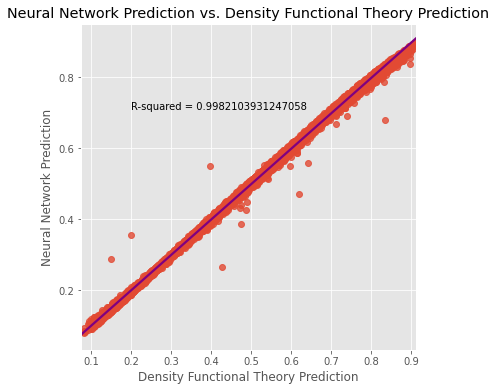

In [124]:
prediction = condense(s_predicted)
observed = condense(s)

plt.figure(figsize=(6, 6))
plt.title('Neural Network Prediction vs. Density Functional Theory Prediction')
plt.ylabel('Neural Network Prediction')
plt.xlabel('Density Functional Theory Prediction')
plt.text(0.20, 0.710, f'R-squared = {score}')
sns.regplot(observed, prediction, line_kws={'color':'purple'});

The error distribution may also be plotted, and it is expected to be Gaussian. In fact, the error distribution will likely exhibit leptokurtic or super-Gaussian behavior due to the general lack of outliers between the two predictors.

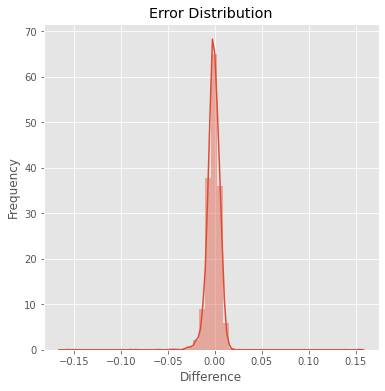

In [121]:
error = np.array(prediction) - np.array(observed)

plt.figure(figsize=(6, 6))
plt.title('Error Distribution')
plt.ylabel('Frequency')
plt.xlabel('Difference')
sns.distplot(error);

The last thing of this neural network model to be visually analyzed would be the predicted atomic coordinates. Keep in mind that due to the high accuracy of either method, the neural network and Density Functional Theory, the visualizations may look nearly identical. Trust, but verify: 

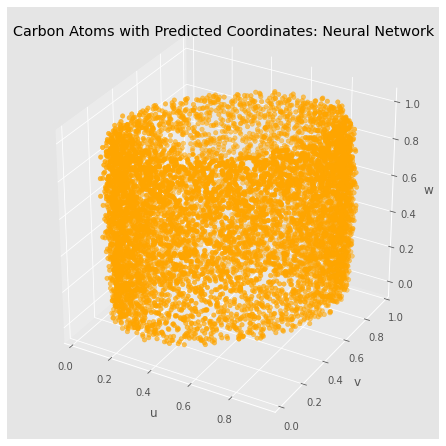

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

nn_u = [val[0] for val in s_predicted.detach().numpy()]
nn_v = [val[1] for val in s_predicted.detach().numpy()]
nn_w = [val[2] for val in s_predicted.detach().numpy()]

plt.title('Carbon Atoms with Predicted Coordinates: Neural Network')
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.scatter(nn_u, nn_v, nn_w, c='orange')
plt.show()

## Measuring Accuracy

So far, the performance of the neural network has been compared against the atomic coordinates *calculated by Density Functional Theory*. Measurements need to be made against Density Functional Theory and the initial coordinates, as well as against the neural network and the initial coordinates. Let the `r2_score` be the indicating metric of a given model's accuracy.

Note that, because the neural network has been trained on `X_train` and therefore shares its length, `X_train` needs to be dismantled into $<u, v, w>$ coordinate form. 

In [18]:
# Excluding the chiral indices
uvw_list = [val[-3:] for val in X_train.values]

# Unravelling the data into u axis, v axis, and w axis respectively
train_u, train_v, train_w = [float(val[0]) for val in uvw_list], [float(val[1]) for val in uvw_list], [float(val[2]) for val in uvw_list]

# Correlation between original points and those calculated by Density Functional Theory
dft_u_score = r2_score(u, up)
dft_v_score = r2_score(v, vp)
dft_w_score = r2_score(w, wp)

# Correlation between the original points and those calculated by the neural network
fnn_u_score = r2_score(train_u, nn_u)
fnn_v_score = r2_score(train_v, nn_v)
fnn_w_score = r2_score(train_w, nn_w)

Similarly to how a tensor $\mathcal{T}$ could be condensed through a defined function, consider condensing the `r2_score`s of an atomic location $<u, v, w>$ into a single score by taking the mean $\mu$ of the coordinates' score:

In [19]:
dft_score = np.array([dft_u_score, dft_v_score, dft_w_score]).mean()
fnn_score = np.array([fnn_u_score, fnn_v_score, fnn_w_score]).mean()

Likewise, condense the atomic location $<u, v, w>$ to a single data point for each sample to visualize the correlation between the original points against either model without having to individually analyze all three axes across three different graphs.

With visualizing the coordinates calculated by Density Functional Theory and its error distribution with respect to the initial coordinates first:

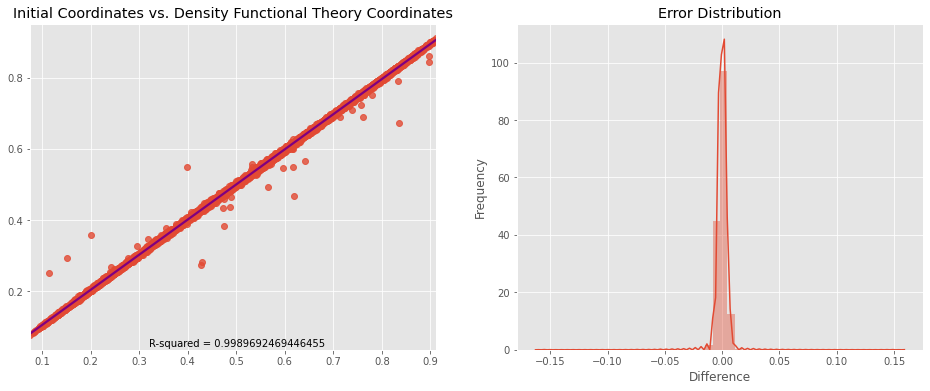

In [93]:
# Condensing the coordinates
uvw_condensed = (u + v + w) / 3
dft_condensed = (up + vp + wp) / 3

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0].title.set_text('Initial Coordinates vs. Density Functional Theory Coordinates')
axes[0].set(xlabel='Density Functional Theory Calculations', ylabel='Observed Initial Coordinates')
plt.text(-0.5, 1.010, f'R-squared = {dft_score}')
sns.regplot(dft_condensed, uvw_condensed, line_kws={'color':'purple'}, ax=axes[0]);

error = np.array(uvw_condensed) - np.array(dft_condensed)

axes[1].title.set_text('Error Distribution')
axes[1].set(xlabel='Difference', ylabel='Frequency')
sns.distplot(error, ax=axes[1]);

Repeating the process for the predicted atomic coordinates from the neural network model:

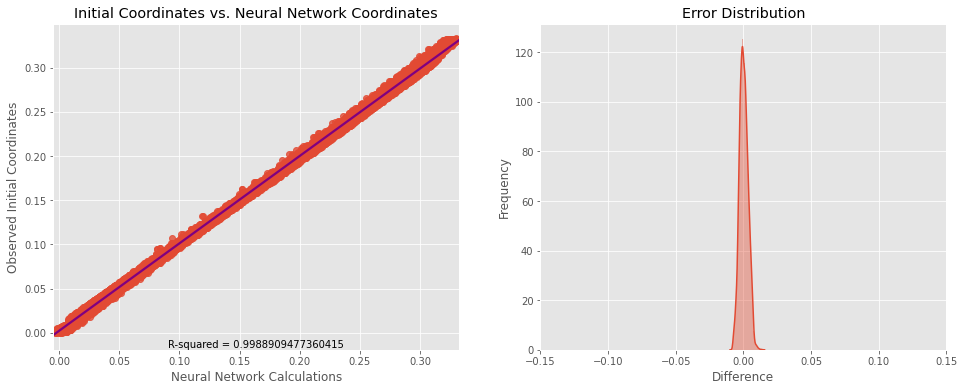

In [110]:
# Condensing the coordinates
train_condensed = np.array(train_u + train_v + train_w) / 3
fnn_condensed = np.array(nn_u + nn_v + nn_w) / 3

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0].title.set_text('Initial Coordinates vs. Neural Network Coordinates')
axes[0].set(xlabel='Neural Network Calculations', ylabel='Observed Initial Coordinates')
plt.text(-0.425, 1.010, f'R-squared = {fnn_score}')
sns.regplot(fnn_condensed, train_condensed, line_kws={'color':'purple'}, ax=axes[0]);

error = np.array(train_condensed) - np.array(fnn_condensed)

axes[1].title.set_text('Error Distribution')
axes[1].set(xlabel='Difference', ylabel='Frequency')
axes[1].set_xlim(-0.15, 0.15)
sns.distplot(error, ax=axes[1]);

The coordinates calculated by Density Functional Theory appear generally precise; however, "precise" may still be an inappropriate adjective with the scale of outliers present in the model. The coordinates predicted by the neural network model are generally not as precise as the coordinates calculated by Density Functional Theory, but will also not generally be far from the true value either.

Note that the mathematical Density Functional Theory can take a good amount of time -- up to days -- calculating atomic values. Therefore, the approach utilizing the feedforward sequential neural network is recommended due to its comparable accuracy and relatively short computing time. 

## Building a Model with XGBoost

Consider a separate approach from the neural network in which a gradient-boosted regression tree, with grid-search-optimized hyperparameters, calculates the atomic coordinates. Compare this regression tree to the performance of the neural network, the performance of the Density Functional Theory approach, and (obviously) to the initial coordinates. 

In [30]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)

clf = GridSearchCV(model,
                   {'estimator__max_depth': [8, 16, 32],
                    'estimator__n_estimators': [50, 100, 200], 
                    'estimator__subsampling': [0.5, 0.75],
                    'estimator__min_child_weight': [0, 1, 2]}, verbose=1)
clf.fit(X_train, y_train);
max_depth, min_child_weight, n_estimators, subsampling = clf.best_params_.values()
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  4.7min finished


0.9989570059352102
{'estimator__max_depth': 8, 'estimator__min_child_weight': 2, 'estimator__n_estimators': 50, 'estimator__subsampling': 0.5}


With GridSearch having optimized the hyperparameters, instantiate a model with the optimal hyperparameters and fit the model to the data.

In [44]:
from sklearn.metrics import mean_squared_error

xgb_mod = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',
                                      max_depth=max_depth,
                                      n_estimators=n_estimators,
                                      subsampling=subsampling,
                                      min_child_weight=min_child_weight)).fit(X_train, y_train)

predict = xgb_mod.predict(X_test)
xgb_score = r2_score(y_test, predict)

Similarly to how the neural network shared the size of `X_train`, the predictions of the XGB model share the size of `X_test`. Therefore, the `X_test` initial coordinates need to be dismantled into $<u, v, w>$ form.

In [55]:
# Excluding the chiral indices
uvw_test = [val[-3:] for val in X_test.values]

# Unravelling the data into u axis, v axis, and w axis respectively
test_u, test_v, test_w = [float(val[0]) for val in uvw_test], [float(val[1]) for val in uvw_test], [float(val[2]) for val in uvw_test]

# Unravelling the predict variable unto the axes
xgb_u, xgb_v, xgb_w = [float(val[0]) for val in predict], [float(val[1]) for val in predict], [float(val[2]) for val in predict]

# Condensing the coordinates
xgb_mean = np.array(xgb_u + xgb_v + xgb_w) / 3
test_condensed = np.array(test_u + test_v + test_w) / 3

Visualize the correlation between the initial coordinates and those predicted by the multi-variate XGB model with the data having been unravelled unto the axes and then condensed into points for `seaborn` compatibility:

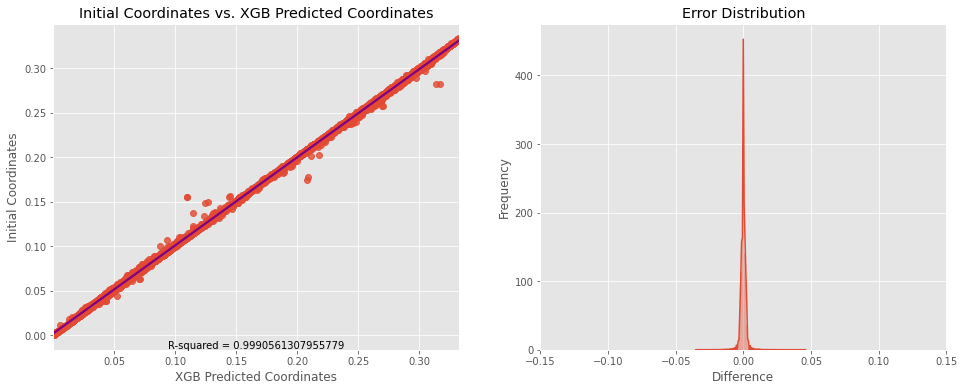

In [114]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0].title.set_text('Initial Coordinates vs. XGB Predicted Coordinates')
axes[0].set(xlabel='XGB Predicted Coordinates', ylabel='Initial Coordinates')
plt.text(-0.425, 1.30, f'R-squared = {xgb_score}')
sns.regplot(xgb_mean, test_condensed, line_kws={'color':'purple'}, ax=axes[0]);

error = np.array(test_condensed) - np.array(xgb_mean)

axes[1].title.set_text('Error Distribution')
axes[1].set(xlabel='Difference', ylabel='Frequency')
axes[1].set_xlim(-0.15, 0.15)
sns.distplot(error, ax=axes[1]);

Plot the atomic coordinates predicted by the multi-variate XGB model into a three dimensional space. Keep in mind that, due to sharing the size of `X_test`, the number of carbon atom samples in the visualization will be significantly reduced.

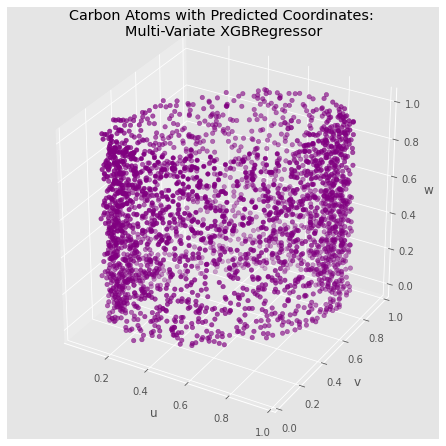

In [116]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

plt.title('Carbon Atoms with Predicted Coordinates: \nMulti-Variate XGBRegressor')
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.scatter(xgb_u, xgb_v, xgb_w, c='purple')
plt.show()

## Conclusion

Despite the accuracy of Density Functional Theory, the comparable accuracy and massive speed-up in computational time of the multi-variate gradient-boosted regression model and the sequential feedforward neural network leaves either of them a better option for calculating the coordinates of carbon atoms. 

Even though the gradient-boosted XGBRegressor performed slightly better than the neural network, the XGBRegressor depends on a `sklearn` wrapper for multi-variable support and a GridSearch for hyperparameter optimization which adds a few minutes to the approach. On the other hand, the performance of the neural network may be improved with, perhaps, a different optimizer, a different activation function, or maybe even an entirely different architecture. Further research can be done into optimizing a neural network for this task (the optimization of a neural network is an open problem in general) and/or expanding the original dataset by adding relevant features and parameters for model construction.

The dataset used in this Jupyter notebook was downloaded from the [University of California, Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Carbon+Nanotubes). A special thanks is to be given to the original authors Mehmet Acı and Mutlu Avcı, whose work is cited below.

Acı, M., Avcı, M. Artificial neural network approach for atomic coordinate prediction of carbon nanotubes. Appl. Phys. A 122, 631 (2016). https://doi.org/10.1007/s00339-016-0153-1